#Modelo LSTM Univariado

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import date
from tqdm import tqdm_notebook 
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Constantes
CV_SIZE = 0.2            # Proporção do dataset utilizado para validação
TEST_SIZE = 0.2          # Proporção do dataset utilizado para teste
    
# Valores iniciais antes da otimização
N = 9                    # Tamanho da janela utilizada no treinamento (window size)
lstm_units=140                 
dropout_prob=0.2               
optimizer='adam'               
epochs=120                     
batch_size=16                  

## Preparação dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Inserir o local da pasta onde estão os arquivos de entrada
workdir_path = '/content/drive/My Drive/' + '/Monografia/Análise do preço de comodities agrícolas'
os.chdir(workdir_path)

Leitura da série histórica do preço do milho

In [ ]:
# Leitura do arquivo csv
ccm = pd.read_csv("./data/CCM.csv", sep=';')
ccm.columns = ["date","ccm_brl", "ccm_usd"]
ccm["date"] = ccm["date"].astype('datetime64[ns]')
ccm['ccm_brl'] = pd.to_numeric(ccm['ccm_brl'], errors='coerce').dropna(0)
ccm['ccm_usd'] = pd.to_numeric(ccm['ccm_usd'], errors='coerce').dropna(0)
commodity_df = ccm
commodity_df = commodity_df.set_index('date')
commodity_df
print(commodity_df)

            ccm_brl  ccm_usd
date                        
2004-08-02    18.24     5.98
2004-08-03    18.04     5.91
2004-08-04    18.02     5.90
2004-08-05    18.06     5.89
2004-08-06    18.13     5.98
...             ...      ...
2021-07-12    96.24    18.62
2021-07-13    96.43    18.65
2021-07-14    97.19    19.16
2021-07-15    98.01    19.12
2021-07-16    97.34    19.01

[4221 rows x 2 columns]


Período selecionado para o estudo [2004 - 2021]

In [ ]:
min_date, max_date = min(commodity_df.index), max(commodity_df.index)
print(f"Peródo de estudo: {pd.Timestamp(min_date).year} à {pd.Timestamp(max_date).year}")

Peródo de estudo: 2004 à 2021


## Análise exploratória dos dados

Gáfico dos preços da commodity

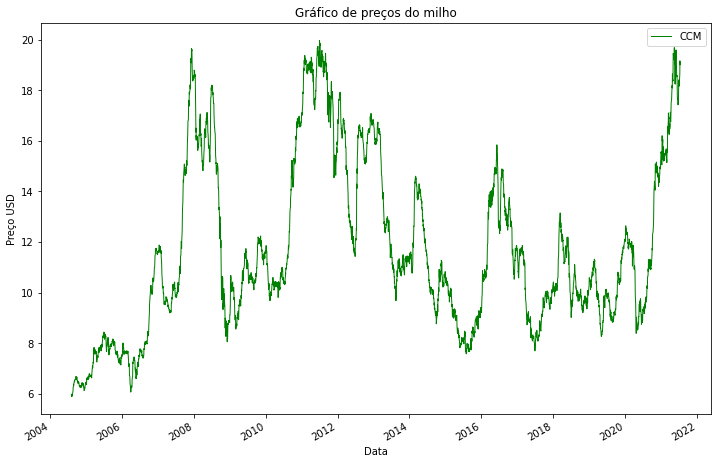

In [ ]:
plt.figure(figsize=(12,8))
ax = commodity_df['ccm_usd'].plot(color='green', lw=1, label='CCM')

plt.title('Gráfico de preços do milho')
plt.xlabel('Data')
plt.ylabel('Preço USD')
plt.legend()
plt.show()

Bx plot do preço do milho

## Construção e treinamento da rede LSTM

#### Funções comuns para calculo de métricas:

In [ ]:
#Função usada para calcular o MAPE
def get_mape(y_true, y_pred): 
    #Compute mean absolute percentage error (MAPE)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Função usada para divide os dados em janelas (features) de acordo com o tamanho do parâmetro N 
def get_x(data, N, offset):
    x = []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
    x = np.array(x)
    return x

#Função usada para treinar, prever e avaliar o modelo
#Retorna mse, rmse, mape e est (valores previstos)
def train_pred_eval_model(x_train_scaled,
                          y_train_scaled,
                          x_cv_scaled,
                          y_cv,
                          scaler,
                          lstm_units,
                          dropout_prob=0.2,
                          optimizer='adam',
                          epochs=100,
                          batch_size=32):

    # Criação da rede LSTM
    model = Sequential()
    # Adiciona a primeira camada LSTM e Dropout
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
    model.add(Dropout(dropout_prob))
    # Adiciona a segunda camada LSTM e Dropout
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adiciona a camada de saída
    model.add(Dense(1))
    # Compila a rede
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    # Treina a rede
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Efetua a previsão
    est_scaled = model.predict(x_cv_scaled)
    # Retorna à escala normal para cálculo das métricas
    est = scaler.inverse_transform(est_scaled.reshape(-1,1)).reshape(-1)
    mse = mean_squared_error(y_cv,est)
    rmse = math.sqrt(mse)
    mape = get_mape(y_cv, est)
    
    return mse, rmse, mape, est

#### Dividindo os dados em conjuntos de treino, validação e teste

In [ ]:
commodity_df_subset = commodity_df[(commodity_df.index.year >2008)].drop(columns=['ccm_brl'])
commodity_df_subset

,ccm_usd
date,
2009-01-02,9.12
2009-01-05,9.53
2009-01-06,10.47
2009-01-07,10.47
2009-01-08,10.49
...,...
2021-07-12,18.62
2021-07-13,18.65
2021-07-14,19.16


In [ ]:
num_cv = int(CV_SIZE * len(commodity_df_subset))
num_test = int(TEST_SIZE * len(commodity_df_subset))
num_train = len(commodity_df_subset) - num_test - num_cv
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))
print("num_train = " + str(num_train))

num_cv = 624
num_test = 624
num_train = 1874


In [ ]:
# Split into train, cv, and test
train = commodity_df_subset[:num_train]
cv = commodity_df_subset[num_train:num_train+num_cv]
train_cv = commodity_df_subset[:num_train+num_cv]
test = commodity_df_subset[num_train+num_cv:]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (1874, 1)
cv.shape = (624, 1)
train_cv.shape = (2498, 1)
test.shape = (624, 1)


In [ ]:
print("train = " + str(train))
print("cv = " + str(cv))
print("train_cv = " + str(train_cv))
print("test = " + str(test))

train =             ccm_usd
date               
2009-01-02     9.12
2009-01-05     9.53
2009-01-06    10.47
2009-01-07    10.47
2009-01-08    10.49
...             ...
2016-07-07    12.46
2016-07-08    12.67
2016-07-11    12.46
2016-07-12    12.69
2016-07-13    12.96

[1874 rows x 1 columns]
cv =             ccm_usd
date               
2016-07-14    13.29
2016-07-15    13.49
2016-07-18    13.84
2016-07-19    14.10
2016-07-20    14.38
...             ...
2019-01-10    10.46
2019-01-11    10.44
2019-01-14    10.47
2019-01-15    10.26
2019-01-16    10.25

[624 rows x 1 columns]
train_cv =             ccm_usd
date               
2009-01-02     9.12
2009-01-05     9.53
2009-01-06    10.47
2009-01-07    10.47
2009-01-08    10.49
...             ...
2019-01-10    10.46
2019-01-11    10.44
2019-01-14    10.47
2019-01-15    10.26
2019-01-16    10.25

[2498 rows x 1 columns]
test =             ccm_usd
date               
2019-01-17    10.12
2019-01-18    10.20
2019-01-21    10.34
2019-01-22    1

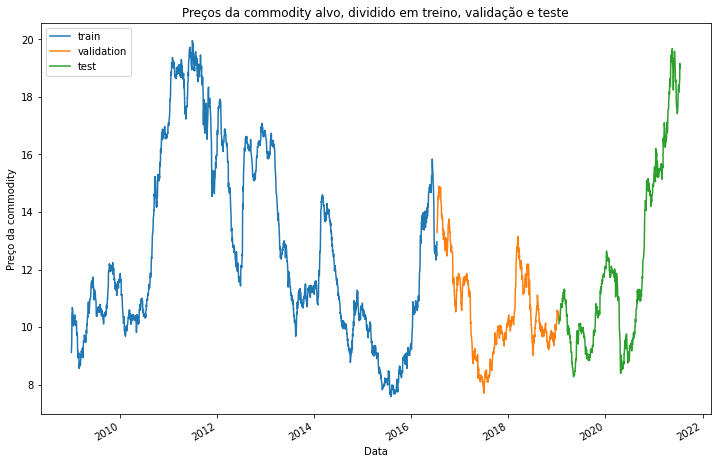

In [ ]:
# Gráfico dos conjuntos de treino, validação e teste concatenados e destacados por cores.
plt.figure(figsize=(12,8))
ax = train['ccm_usd'].plot(label='train')
ax = cv['ccm_usd'].plot(ax=ax, label='validation')
test['ccm_usd'].plot(ax=ax, label='test')

plt.title('Preços da commodity alvo, dividido em treino, validação e teste')
plt.xlabel('Data')
plt.ylabel('Preço da commodity')
plt.legend()
plt.show()

#### Normalização dos dados de Treino e validação

In [ ]:
# Normalizamos apenas o dataset de treino e as features do dataset de validação, para evitar perda de informação

scaler_features = MinMaxScaler()
scaler_y_train = MinMaxScaler()
scaler_y_cv = MinMaxScaler()

train_scaled = scaler_features.fit_transform(train.iloc[:, 0:1].values)
print("train_scaled.shape = " + str(train_scaled.shape)) 

# Split into x and y
x_train_scaled = get_x(train_scaled, N, N)
y_train_scaled = scaler_y_train.fit_transform(train.iloc[N:, 0:1].values) #só coluna da série alvo
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) 
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) 

train_scaled.shape = (1874, 1)
x_train_scaled.shape = (1865, 9, 1)
y_train_scaled.shape = (1865, 1)


In [ ]:
# Scale the cv dataset
cv_scaled = scaler_features.fit_transform(cv.iloc[:, 0:4].values)
print("cv_scaled.shape = " + str(cv_scaled.shape)) 

# Split into x and y
x_cv_scaled = get_x(cv_scaled, N, N)
y_cv = cv.iloc[N:, 0:1].values #só coluna da série alvo

y_cv_scaled = scaler_y_cv.fit_transform(y_cv)

print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))

cv_scaled.shape = (624, 1)
x_cv_scaled.shape = (615, 9, 1)
y_cv.shape = (615, 1)


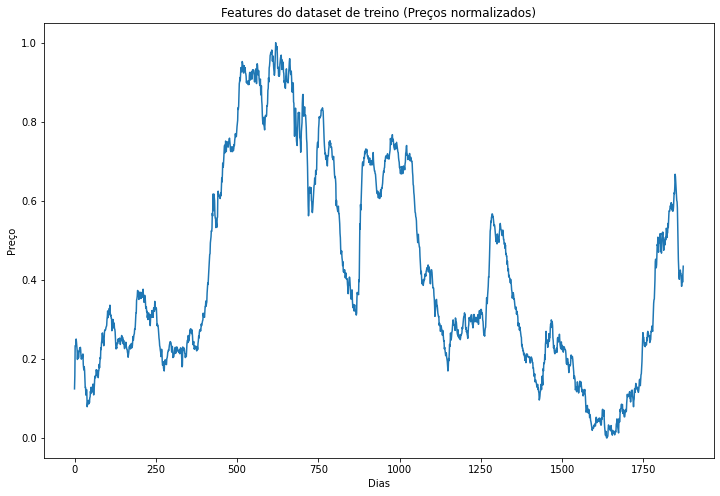

In [ ]:
# Mostra as features do dataset de treino
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(train_scaled)
plt.xlabel("Dias")
plt.ylabel("Preço")
plt.title("Features do dataset de treino (Preços normalizados)")
plt.show()

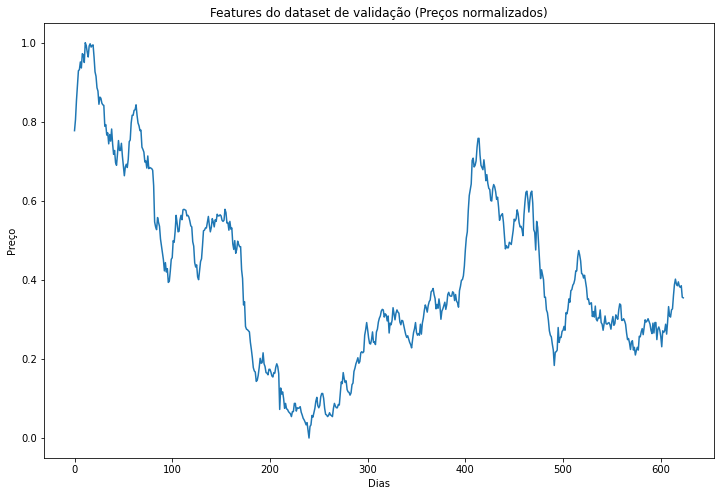

In [ ]:
# Mostra as features do dataset de validação
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(cv_scaled)
plt.xlabel("Dias")
plt.ylabel("Preço")
plt.title("Features do dataset de validação (Preços normalizados)")
plt.show()

#### Construção e treinamento da rede LSTM

In [ ]:
# Criação da rede LSTM
model = Sequential()
# Adiciona a primeira camada LSTM e Dropout
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
model.add(Dropout(dropout_prob))
# Adiciona a segunda camada LSTM e Dropout
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
# Adiciona a camada de saída
model.add(Dense(1))
# Compila a rede
model.compile(loss='mean_squared_error', optimizer=optimizer)
# Treina a rede
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# Visualiza os parâmetros da rede
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 140)            79520     
_________________________________________________________________
dropout (Dropout)            (None, 9, 140)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 140)               157360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 141       
Total params: 237,021
Trainable params: 237,021
Non-trainable params: 0
_________________________________________________________________


#### Previsão inicial com dados de validação (antes da otimização dos hiperparâmetros)

In [ ]:
# Efetua a previsão sobre os dados de validação 
est_scaled = model.predict(x_cv_scaled)
# Retorno à escala normal para cálculo das métricas
est = scaler_y_cv.inverse_transform(est_scaled.reshape(-1,1)).reshape(-1)

# Calcula MSE
mse_bef_tuning = mean_squared_error(y_cv, est)
print("MSE = %0.3f" % mse_bef_tuning)
# Calcula RMSE 
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calcula MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

MSE = 0.023
RMSE = 0.152
MAPE = 16.655%


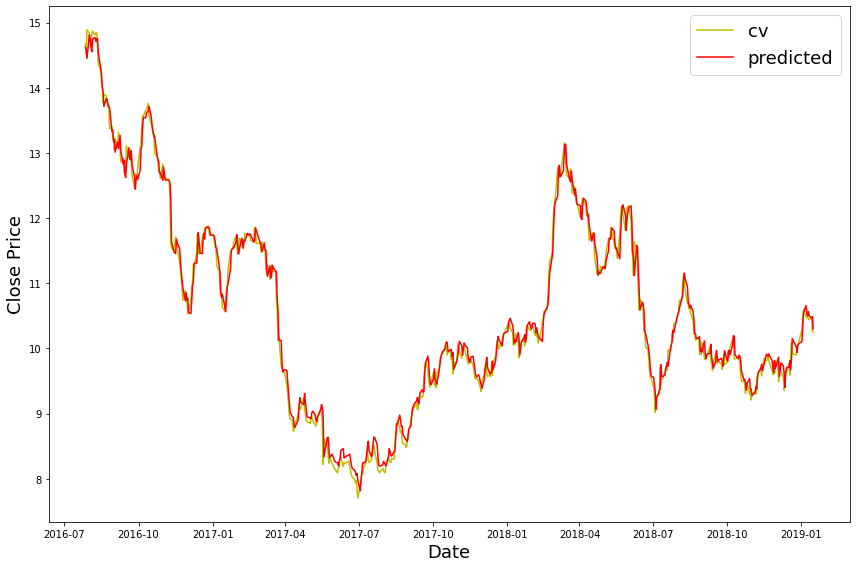

In [ ]:
# Estrutura os dados de validação original e previsto para apresentação
y_cv_df = cv[N:].ccm_usd
est_df = pd.DataFrame({'est': est.reshape(-1), 'y_cv': y_cv.reshape(-1)}, index=y_cv_df.index)
# Gráfico dos resultados original e previsto dos dados de validação 
plt.figure(figsize=(12,8))
plt.plot(y_cv_df, 'y-', label='cv')
plt.plot(est_df[['est']], 'r-', label='predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
#Salva o resultado da previsão antes da otimização de hiperparâmetros
est_df.to_csv("./univariado_lstm_previsao_inicial_antes_da_otimizacao.csv")
est_df

,est,y_cv
date,,
2016-07-27,14.622582,14.67
2016-07-28,14.588130,14.53
2016-07-29,14.451960,14.89
2016-08-01,14.812049,14.84
2016-08-02,14.739613,14.72
...,...,...
2019-01-10,10.565192,10.46
2019-01-11,10.504034,10.44
2019-01-14,10.463034,10.47


#### Otimização do número de dias da janela de features (window-size)

In [ ]:
#param_range = range(6, 24, 3)
#for param in param_range:
#  print(param)

In [ ]:
param_label = 'N'
param_range = range(6, 24, 3)

error_rate = {param_label : [], 'mse': [], 'rmse': [], 'mape': []}
tic = time.time()

for param in tqdm_notebook(param_range):
    
    # Split train into x and y
    x_train_scaled = get_x(train_scaled, param, param)
    y_train_scaled = train_scaled[param:, 0:1]
    #print("x_train_scaled.shape = " + str(x_train_scaled.shape)) 
    #print("y_train_scaled.shape = " + str(y_train_scaled.shape))
    
    # Split cv into x and y
    x_cv_scaled = get_x(cv_scaled, param, param)
    y_cv = cv.iloc[param:, 0:1].values #só coluna da série alvo
    y_cv_scaled = scaler_y_cv.fit_transform(y_cv)
    #print("x_cv_scaled.shape = " + str(x_cv_scaled.shape)) 
    #print("y_cv.shape = " + str(y_cv.shape)) 

    # A função abaixo serve para treinar, gerar a previsão e avaliar os resultados através da função de perda
    mse, rmse, mape, est_N = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                          x_cv_scaled, y_cv, scaler_y_cv,
                                          lstm_units=lstm_units,
                                          dropout_prob=dropout_prob,
                                          optimizer=optimizer,
                                          epochs=epochs,
                                          batch_size=batch_size)
    
    # Coleta os resultados
    error_rate[param_label].append(param)
    error_rate['mse'].append(mse)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Tempo em minutos: {}'.format((toc - tic) / 60.0))
error_rate

  0%|          | 0/6 [00:00<?, ?it/s]

Tempo em minutos: 42.64279353618622


,N,mse,rmse,mape
0,6,0.024657,0.157026,17.219541
1,9,0.022654,0.150513,16.980421
2,12,0.020816,0.144277,16.671590
3,15,0.030774,0.175424,16.839202
4,18,0.021500,0.146627,16.137467
5,21,0.060718,0.246411,15.240291


In [ ]:
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv("./univariado_lstm_otimizacao_window_size.csv")

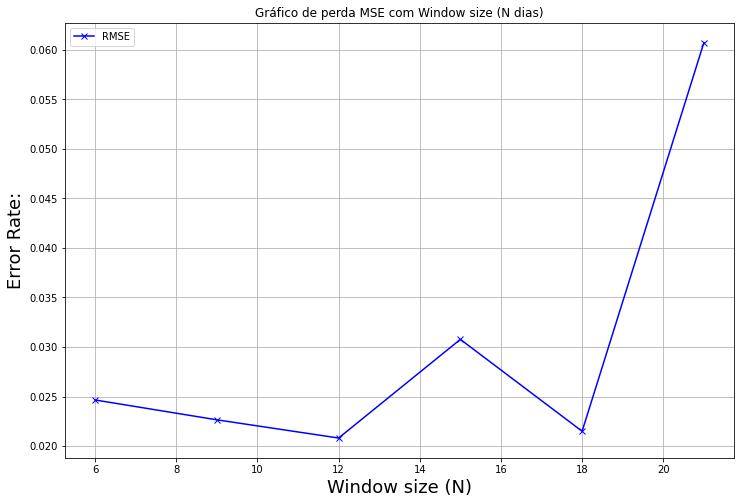

In [ ]:
# Plot MSE
plt.figure(figsize=(12, 8))
plt.plot(error_rate[param_label], error_rate['mse'], 'bx-', label='RMSE')
#plt.plot(error_rate[param_label], error_rate['mape'], 'rx-', label='MAPE')
plt.xlabel('Window size (N)', fontsize=18)
plt.ylabel('Error Rate:', fontsize=18)
plt.title('Gráfico de perda MSE com Window size (N dias)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Get optimum value for param
temp = error_rate[error_rate['mse'] == error_rate['mse'].min()]
N_opt = temp['N'].values[0]
print("min MSE = %0.3f" % error_rate['mse'].min())
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(N_opt))

min MSE = 0.021
min RMSE = 0.144
min MAPE = 15.240%
optimum N = 12


#### Otimização do número de épocas (epochs) e lote (batch_size)

In [ ]:
param_label = 'epochs'
epochs_list = [100, 120, 140, 160, 180, 200]

param_label1 = 'batch_size'
batch_size_list = [16, 32]

# Split train into x and y
x_train_scaled = get_x(train_scaled, N_opt, N_opt)
y_train_scaled = train_scaled[N_opt:, 0:1]
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

# Split cv into x and y
x_cv_scaled = get_x(cv_scaled, N_opt, N_opt)
y_cv = cv.iloc[N_opt:, 0:1].values #só coluna da série alvo
y_cv_scaled = scaler_y_cv.fit_transform(y_cv)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))

error_rate = {param_label : [], param_label1: [], 'mse': [], 'rmse': [], 'mape': []}
tic = time.time()

for epoch in tqdm_notebook(epochs_list):
   
    for batch_len in tqdm_notebook(batch_size_list):
        # train, predict and eval with LSTM model
        mse, rmse, mape, est_epoc = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                              x_cv_scaled, y_cv, scaler_y_cv,
                                              lstm_units=lstm_units,
                                              dropout_prob=dropout_prob,
                                              optimizer=optimizer,
                                              epochs=epoch,
                                              batch_size=batch_len)

        # Collect results
        error_rate[param_label].append(epoch)
        error_rate[param_label1].append(batch_len)
        error_rate['mse'].append(mse)                             
        error_rate['rmse'].append(rmse)
        error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Tempo em minutos: {}'.format((toc - tic) / 60.0))
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv("./univariado_lstm_otimizacao_epochs_batch.csv")
error_rate

x_train_scaled.shape = (1862, 12, 1)
y_train_scaled.shape = (1862, 1)
x_cv_scaled.shape = (612, 12, 1)
y_cv.shape = (612, 1)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Tempo em minutos: 81.40612862507503


,epochs,batch_size,mse,rmse,mape
0,100,16,0.023436,0.153089,16.543081
1,100,32,0.022459,0.149864,16.585127
2,120,16,0.030080,0.173435,17.109366
3,120,32,0.030888,0.175748,17.006949
4,140,16,0.022781,0.150934,16.702006
5,140,32,0.025129,0.158520,16.419290
6,160,16,0.025925,0.161011,16.999649
7,160,32,0.022388,0.149625,16.810385
8,180,16,0.021183,0.145544,16.466706
9,180,32,0.021413,0.146330,16.515707


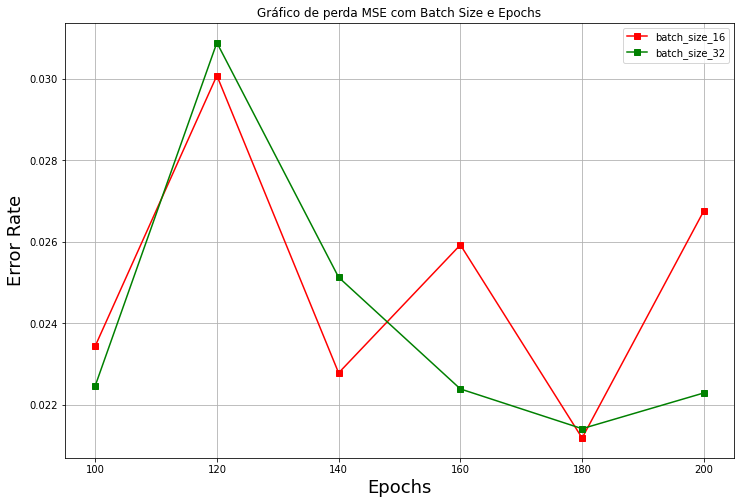

In [ ]:
## Plot MSE With Epochs and Batch_size
plt.figure(figsize=(12, 8))
color_list = ['r', 'g', 'k', 'y', 'm']

for i in range(len(batch_size_list)):
    plt.plot(epochs_list, error_rate.loc[error_rate[param_label1] == batch_size_list[i], 'mse'], 
             color_list[i % len(color_list)], marker='s', label='batch_size_' + str(batch_size_list[i]))
    
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Error Rate', fontsize=18)
plt.title('Gráfico de perda MSE com Batch Size e Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Get optimum value for batch_size and epoch
temp = error_rate[error_rate['mse'] == error_rate['mse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param_label1].values[0]
print("min MSE = %0.3f" % error_rate['mse'].min())
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param_label1 + " = " + str(batch_size_opt))

min MSE = 0.021
min RMSE = 0.146
min MAPE = 16.419%
optimum epochs = 180
optimum batch_size = 16


#### Otimização do número de neurônios (units) e taxa de eliminação (dropout)

In [ ]:
param_label = 'lstm_units'
lstm_unit_list = [100, 120, 140, 160, 180, 200]

param_label1 = 'dropout_prob'
dropout_list = [0.2]

# Split train into x and y
x_train_scaled = get_x(train_scaled, N_opt, N_opt)
y_train_scaled = train_scaled[N_opt:, 0:1]
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

# Split cv into x and y
x_cv_scaled = get_x(cv_scaled, N_opt, N_opt)
y_cv = cv.iloc[N_opt:, 0:1].values #só coluna da série alvo
y_cv_scaled = scaler_y_cv.fit_transform(y_cv)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))

error_rate = {param_label : [], param_label1: [], 'mse': [], 'rmse': [], 'mape': []}
tic = time.time()

for no_lstm_unit in tqdm_notebook(lstm_unit_list):
    
    for dropout in tqdm_notebook(dropout_list):
        # train, predict and eval with LSTM model
        print(f'Excuting For {no_lstm_unit} units and with dropout probability {dropout}')
        mse, rmse, mape, est_unit = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                              x_cv_scaled, y_cv, scaler_y_cv,
                                              lstm_units=no_lstm_unit,
                                              dropout_prob=dropout,
                                              optimizer=optimizer,
                                              epochs=epochs_opt,
                                              batch_size=batch_size_opt)

        # Collect results
        error_rate[param_label].append(no_lstm_unit)
        error_rate[param_label1].append(dropout) 
        error_rate['mse'].append(mse)                              
        error_rate['rmse'].append(rmse)
        error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Tempo em minutos: {}'.format((toc - tic) / 60.0))
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv("./univariado_lstm_otimizacao_unit_dropout.csv")
error_rate

x_train_scaled.shape = (1862, 12, 1)
y_train_scaled.shape = (1862, 1)
x_cv_scaled.shape = (612, 12, 1)
y_cv.shape = (612, 1)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 100 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 120 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 140 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 160 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 180 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 200 units and with dropout probability 0.2
Tempo em minutos: 72.21887240012487


,lstm_units,dropout_prob,mse,rmse,mape
0,100,0.2,0.021622,0.147043,16.760724
1,120,0.2,0.022088,0.148620,16.519357
2,140,0.2,0.021836,0.147769,16.769711
3,160,0.2,0.021928,0.148081,16.451514
4,180,0.2,0.028802,0.169711,16.330906
5,200,0.2,0.021841,0.147787,16.388913


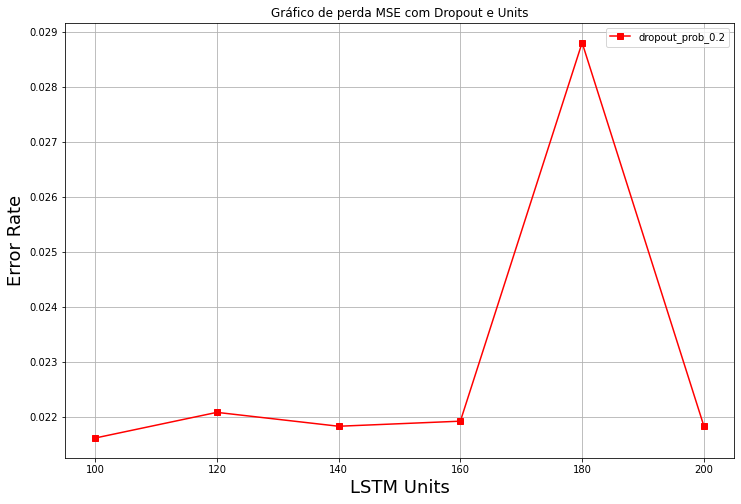

In [ ]:
## Plot MSE With LSTM units and dropout probabilities
plt.figure(figsize=(12, 8))
color_list = ['r', 'g', 'k', 'y', 'm']

for i in range(len(dropout_list)):
    plt.plot(lstm_unit_list, error_rate.loc[error_rate[param_label1] == dropout_list[i], 'mse'], 
             color_list[i % len(color_list)], marker='s', label='dropout_prob_' + str(dropout_list[i]))
    
plt.xlabel('LSTM Units', fontsize=18)
plt.ylabel('Error Rate', fontsize=18)
plt.title('Gráfico de perda MSE com Dropout e Units')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Get optimum value for lstm units and dropout probs
temp = error_rate[error_rate['mse'] == error_rate['mse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param_label1].values[0]
print("min MSE = %0.3f" % error_rate['mse'].min())
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param_label1 + " = " + str(dropout_prob_opt))

min MSE = 0.022
min RMSE = 0.147
min MAPE = 16.331%
optimum lstm_units = 100
optimum dropout_prob = 0.2


#### Parametros otimizados

In [ ]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'epochs', 'batch_size', 'mse', 'rmse', 'mape'],
     'original': [N, lstm_units, dropout_prob, epochs, batch_size, mse_bef_tuning, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, epochs_opt, batch_size_opt, error_rate['mse'].min(), error_rate['rmse'].min(), 
                      error_rate['mape'].min()]}
tuned_params = pd.DataFrame(d)
#Salva os hiperparâmetros após a otimização
tuned_params.to_csv("./univariado_lstm_hiperparametros_otimizados.csv")
tuned_params

,param,original,after_tuning
0,N,9.000000,12.000000
1,lstm_units,140.000000,100.000000
2,dropout_prob,0.200000,0.200000
3,epochs,120.000000,180.000000
4,batch_size,16.000000,16.000000
5,mse,0.023131,0.021622
6,rmse,0.152088,0.147043
7,mape,16.655180,16.330906


## Modelo final

In [ ]:
#N_opt=12
#lstm_units_opt=180
#dropout_prob_opt=0.2
#epochs_opt=200
#batch_size_opt=32

In [ ]:
# Here we scale the train_cv set, for the final model
#scaler_final = StandardScaler()
scaler_final = MinMaxScaler()
train_cv_scaled_final = scaler_final.fit_transform(train_cv.iloc[:, 0:1].values) #só coluna da série em si

# Split train_cv into x and y
x_train_cv_scaled = get_x(train_cv_scaled_final, N_opt, N_opt)
y_train_cv_scaled = train_cv_scaled_final[N_opt:, 0:1]
print("x_train_cv_scaled.shape = " + str(x_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))

# Here we scale the test set, for the final model
test_scaled = scaler_features.fit_transform(test.iloc[:, 0:1].values) #só coluna da série em si

# Split test into x and y
#scaler_test = StandardScaler()
scaler_test = MinMaxScaler()
x_test_scaled = get_x(test_scaled, N_opt, N_opt)
y_test = test.iloc[N_opt:, 0:1].values #só coluna da série alvo
y_test_scaled = scaler_test.fit_transform(y_test)


print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))

x_train_cv_scaled.shape = (2486, 12, 1)
y_train_cv_scaled.shape = (2486, 1)
x_test_scaled.shape = (612, 12, 1)
y_test.shape = (612, 1)


In [ ]:
# Train, predict and eval model
mse, rmse, mape, est = train_pred_eval_model(x_train_cv_scaled,
                                        y_train_cv_scaled,
                                        x_test_scaled,
                                        y_test,
                                        scaler_test,
                                        lstm_units=lstm_units_opt,
                                        dropout_prob=dropout_prob_opt,
                                        optimizer=optimizer,
                                        epochs=epochs_opt,
                                        batch_size=batch_size_opt)

# Calculate MSE
print("MSE on test set = %0.3f" % mse)
# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)
# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

MSE on test set = 0.038
RMSE on test set = 0.194
MAPE on test set = 28.179%


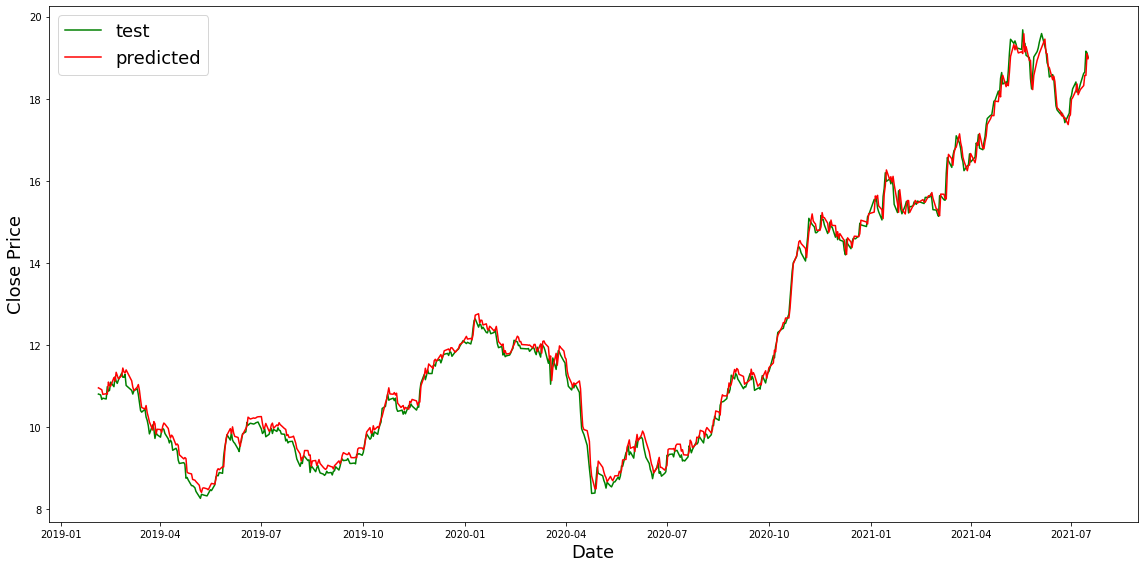

In [ ]:
y_test = test.iloc[N_opt:, 0:1].values #coluna da série alvo original
y_test_df = test[N_opt:].ccm_usd
est_df = pd.DataFrame({'est': est.reshape(-1), 'y_test': y_test.reshape(-1)}, index= y_test_df.index)

# Plot true and predicted price over time 
plt.figure(figsize=(16, 8))
#plt.plot(cv, 'y-', label='cv')
plt.plot(y_test_df, 'g-', label='test')
plt.plot(est_df[['est']], 'r-', label='predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

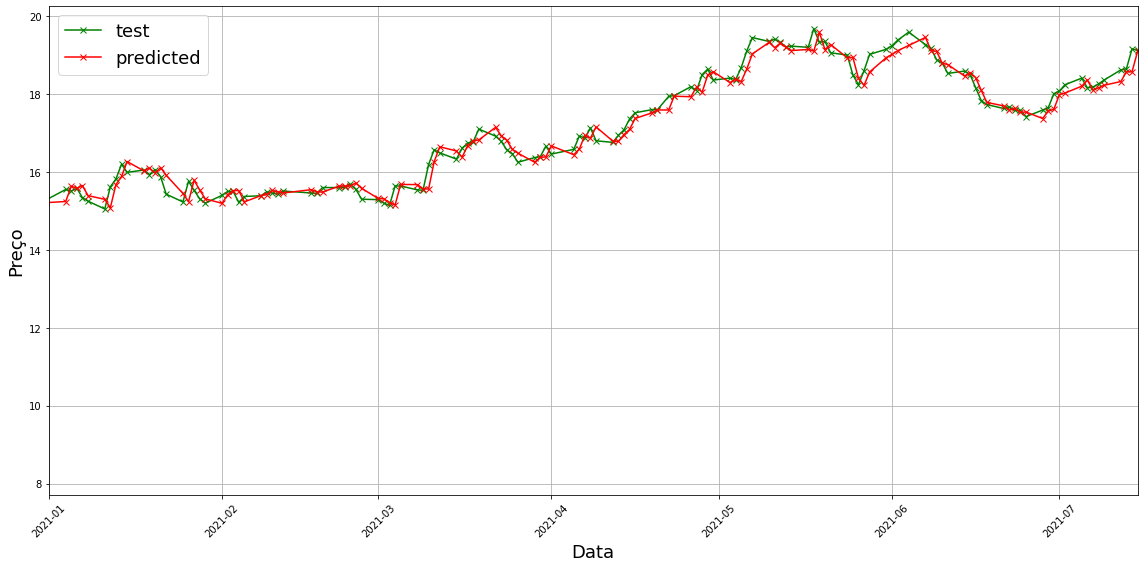

In [ ]:
# Zoom on the test set
plt.figure(figsize=(16, 8))
# plt.plot(cv, 'y-', label='cv')
plt.plot(y_test_df, 'gx-', label='test')
plt.plot(est_df[['est']], 'rx-', label='predicted')
plt.xlim([date(2021, 1, 1), date(2021, 7, 15)])
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_lstm = est_df
#Salva o resultado da previsão após a otimização de hiperparâmetros
test_lstm.to_csv("./univariado_lstm_previsao_final_apos_otimizacao.csv")
test_lstm

,est,y_test
date,,
2019-02-04,10.961330,10.81
2019-02-05,10.945073,10.80
2019-02-06,10.926997,10.79
2019-02-07,10.915332,10.68
2019-02-08,10.802877,10.71
...,...,...
2021-07-12,18.321598,18.62
2021-07-13,18.572222,18.65
2021-07-14,18.569563,19.16
